## Setup: imports and global variables

Customize variables and run this cell first.

In [15]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import data_analysis as da

DATA_ROOT = os.path.join(os.environ['HOME'], 'rib-fracture', 'data')

DATASET_ROOT = os.path.join(DATA_ROOT, 'ribfrac')
ANALYSIS_ROOT = os.path.join(DATA_ROOT, 'analysis')

# default dataset directory tree
TRAIN_IMAGES = os.path.join(DATASET_ROOT, 'ribfrac-train-images')
TRAIN_LABELS = os.path.join(DATASET_ROOT, 'ribfrac-train-labels')
TRAIN_INFO = os.path.join(DATASET_ROOT, 'ribfrac-train-info.csv')
#VAL_IMAGES = os.path.join(DATASET_ROOT, 'ribfrac-val-images')
#VAL_LABELS = os.path.join(DATASET_ROOT, 'ribfrac-val-labels')
#VAL_INFO = os.path.join(DATASET_ROOT, 'ribfrac-val-info.csv')

## Generate rib data

Generate data to be used later in the notebook. `rib_data` contains information about fracture types per scan.

In [16]:
rib_data = da.compute_rib_data([TRAIN_INFO])

In [17]:
nr_frac = {k: len(v) for k, v in rib_data.items()}
rib_frac_types = {name: 0 for name in da.LABEL_CODE.values()}
for k, v in rib_data.items():
    for frac_code in v:
        if frac_code != 0:  # ignore background
            rib_frac_types[da.LABEL_CODE[frac_code]] += 1
        
print('rib_data=', rib_data)
print('nr_frac=', nr_frac)
print('rib_frac_types=', rib_frac_types)

total_rib_frac = sum(rib_frac_types.values())
avg_frac = total_rib_frac/len(nr_frac)
print('average fractures', avg_frac)
print('total fractures',total_rib_frac)

rib_data= defaultdict(<class 'list'>, {'RibFrac1': [0, 2, 2], 'RibFrac2': [0, -1, -1, -1, 2, 2, 2, -1, -1, -1], 'RibFrac3': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 3], 'RibFrac4': [0, 2, 2, 1, 1, -1, 2], 'RibFrac5': [0, 2, 2], 'RibFrac6': [0, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1], 'RibFrac7': [0, 2, -1, 2, -1, -1, -1], 'RibFrac8': [0, 1, 1, 1, 4, 4, 2, -1, 2, 4, -1, -1], 'RibFrac9': [0, -1, -1, -1, -1, -1, 1, -1, -1, 1, 4, -1, -1, -1, 1, -1, -1], 'RibFrac10': [0, -1, -1, 3, -1, 3, 3, 1, 2], 'RibFrac11': [0, 3, 2], 'RibFrac12': [0, -1, -1, 2, 4, 4, 1], 'RibFrac13': [0, -1, -1, -1, 2, 1, -1, 1, -1, -1], 'RibFrac14': [0, -1, 1, -1, -1, -1, 2], 'RibFrac15': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1], 'RibFrac16': [0, -1, -1, -1, -1, -1, 1, 3, 3, 1, 3, -1, -1, -1, -1, -1], 'RibFrac17': [0, 1, 1, 1, 1, 3, 1, -1, -1, -1, -1, 2, 3, -1, -1, -1, -1, -1, -1], 'RibFrac18': [0, -1, -1, -1, 1, 1, -1, -1, 3, 3], 'RibFrac19': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 4, 

### Fracture type analysis

We plot the amount of fractures for each type.

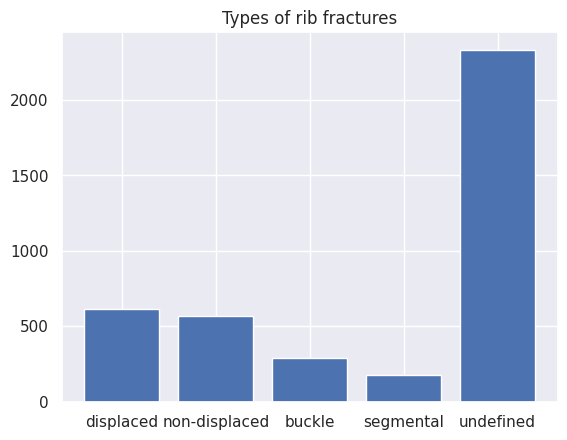

In [18]:
plt.bar(list(rib_frac_types.keys())[1:],list(rib_frac_types.values())[1:])
plt.title('Types of rib fractures')
plt.show()

## Fracture analysis

If present, loads existing analysis. Otherwise, fracture analysis is computed. It might take time to run (estimation: 30min). It generates 2 dataframes:
- `df_scan`: contains information about scan size
- `df_frac`: contains geometric information about fractures, including sizes and location distributions

In [19]:
if os.path.exists(os.path.join(ANALYSIS_ROOT, 'scan.csv')):
    df_scan = pd.read_csv(os.path.join(ANALYSIS_ROOT, 'scan.csv'))
    df_frac = pd.read_csv(os.path.join(ANALYSIS_ROOT, 'frac.csv'))
    print('Loaded existing analysis')
else:
    print('No existing analysis found, computing...')
    df_scan, df_frac = da.fracture_label_analysis(TRAIN_LABELS, rib_data)
    os.makedirs(ANALYSIS_ROOT, exist_ok=True)
    df_scan.to_csv(os.path.join(ANALYSIS_ROOT, 'scan.csv'), index=False)
    df_frac.to_csv(os.path.join(ANALYSIS_ROOT, 'frac.csv'), index=False)
    print('Saved files:',
          os.path.join(ANALYSIS_ROOT, 'scan.csv'),
          os.path.join(ANALYSIS_ROOT, 'frac.csv'),
          sep='\n\t')

# fix: ignore background if present
df_frac = df_frac[df_frac['frac_code'] != 0].reset_index(drop=True)

Loaded existing analysis


### Analize fracture data

We show numerical values and statistics of several useful parameters.

In [20]:
df_scan.head()

,public_id,size_x,size_y,size_z
0,RibFrac29,512,512,373
1,RibFrac111,512,512,353
2,RibFrac151,512,512,365
3,RibFrac350,512,512,333
4,RibFrac132,512,512,387


In [21]:
df_frac.head()

,public_id,frac_idx,frac_code,frac_code_name,min_x,max_x,min_y,max_y,min_z,max_z,...,rel_max_z,rel_com_x,rel_com_y,rel_com_z,rel_size_x,rel_size_y,rel_size_z,rel_loc_x,rel_loc_y,rel_loc_z
0,RibFrac29,1,3,buckle,210,248,393,414,220,240,...,0.643432,0.451115,0.789787,0.619699,0.074219,0.041016,0.053619,0.447266,0.788086,0.616622
1,RibFrac29,2,1,displaced,209,240,396,414,193,212,...,0.568365,0.437403,0.791121,0.543508,0.060547,0.035156,0.050938,0.438477,0.791016,0.542895
2,RibFrac29,3,1,displaced,220,256,401,418,177,196,...,0.525469,0.462378,0.799819,0.499392,0.070312,0.033203,0.050938,0.464844,0.799805,0.500000
3,RibFrac29,4,1,displaced,239,277,405,423,159,181,...,0.485255,0.499157,0.808344,0.458326,0.074219,0.035156,0.058981,0.503906,0.808594,0.455764
4,RibFrac111,1,2,non-displaced,159,182,128,159,154,171,...,0.484419,0.332066,0.286144,0.461756,0.044922,0.060547,0.048159,0.333008,0.280273,0.460340


In [22]:
df_scan.describe()

,size_x,size_y,size_z
count,419.0,419.0,419.000000
mean,512.0,512.0,367.078759
std,0.0,0.0,51.726378
min,512.0,512.0,239.000000
25%,512.0,512.0,333.000000
50%,512.0,512.0,357.000000
75%,512.0,512.0,403.000000
max,512.0,512.0,721.000000


In [23]:
df_frac.describe()

,frac_idx,frac_code,min_x,max_x,min_y,max_y,min_z,max_z,volume,com_x,...,rel_max_z,rel_com_x,rel_com_y,rel_com_z,rel_size_x,rel_size_y,rel_size_z,rel_loc_x,rel_loc_y,rel_loc_z
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,...,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000
mean,6.900731,0.255228,245.714538,272.827664,255.886117,278.738977,199.358781,214.382212,4340.455278,259.278566,...,0.580753,0.506403,0.522015,0.560568,0.052955,0.044634,0.041221,0.506389,0.522095,0.560143
std,5.279031,1.618976,78.490351,78.472550,135.811224,135.517387,74.454493,74.410559,5171.445018,78.294138,...,0.177342,0.152918,0.265207,0.177875,0.033030,0.026463,0.023867,0.152392,0.264639,0.177790
min,1.000000,-1.000000,75.000000,95.000000,15.000000,39.000000,0.000000,12.000000,78.000000,87.059023,...,0.043011,0.170037,0.057606,0.019142,0.005859,0.001953,0.000000,0.169922,0.056641,0.021505
25%,3.000000,-1.000000,183.000000,210.000000,116.000000,139.000000,146.000000,159.000000,1313.000000,195.496667,...,0.453782,0.381829,0.248692,0.432958,0.031250,0.029297,0.027714,0.382812,0.250000,0.432166
50%,6.000000,-1.000000,228.000000,260.000000,310.000000,341.000000,198.000000,215.000000,3245.000000,244.025157,...,0.592075,0.476612,0.640791,0.570720,0.046875,0.039062,0.039387,0.476562,0.639648,0.570755
75%,9.000000,2.000000,311.000000,341.000000,384.000000,406.000000,248.000000,263.000000,5413.000000,325.540940,...,0.720000,0.635822,0.774138,0.700732,0.064453,0.050781,0.049853,0.635742,0.772461,0.700456
max,36.000000,4.000000,493.000000,506.000000,470.000000,489.000000,527.000000,556.000000,88447.000000,497.295533,...,0.998138,0.971280,0.936066,0.997229,0.324219,0.267578,0.316176,0.970703,0.936523,0.996437


In [24]:
df_frac.columns

Index(['public_id', 'frac_idx', 'frac_code', 'frac_code_name', 'min_x',
       'max_x', 'min_y', 'max_y', 'min_z', 'max_z', 'volume', 'com_x', 'com_y',
       'com_z', 'max2dsize_x', 'max2dsize_y', 'min2darea', 'max2darea',
       'size_x', 'loc_x', 'size_y', 'loc_y', 'size_z', 'loc_z', 'rel_min_x',
       'rel_min_y', 'rel_min_z', 'rel_max_x', 'rel_max_y', 'rel_max_z',
       'rel_com_x', 'rel_com_y', 'rel_com_z', 'rel_size_x', 'rel_size_y',
       'rel_size_z', 'rel_loc_x', 'rel_loc_y', 'rel_loc_z'],
      dtype='object')

### Select `patch_size` hyperparameter

We plot different sizes of 3d and 2d fracture regions to make a decision on which `patch_size` to use.

Empirically, we choose `pathc_size=64` to be the best.

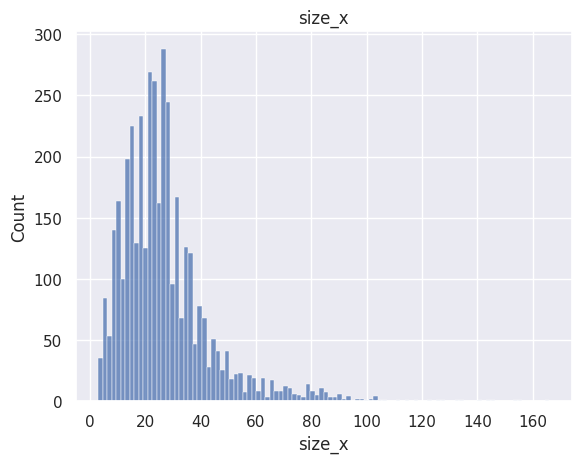

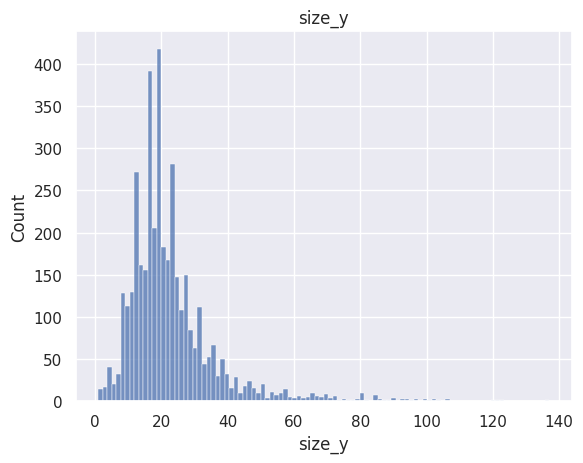

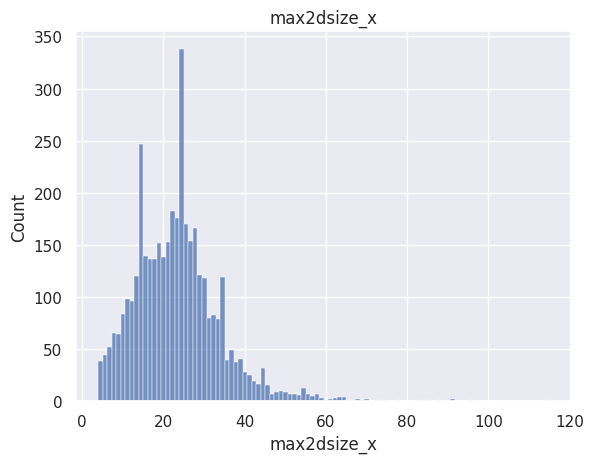

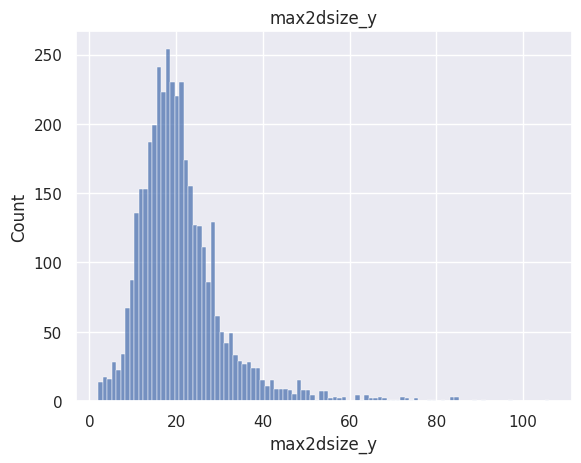

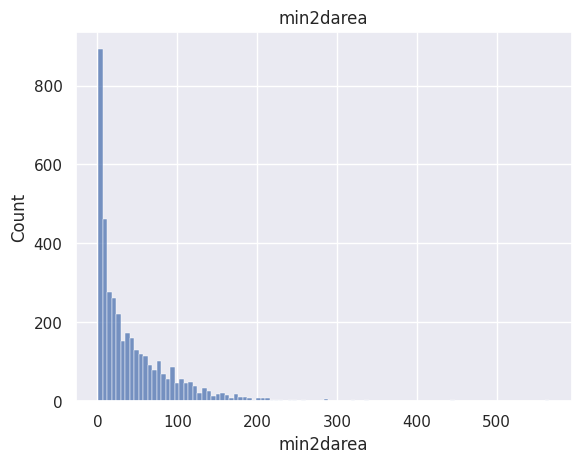

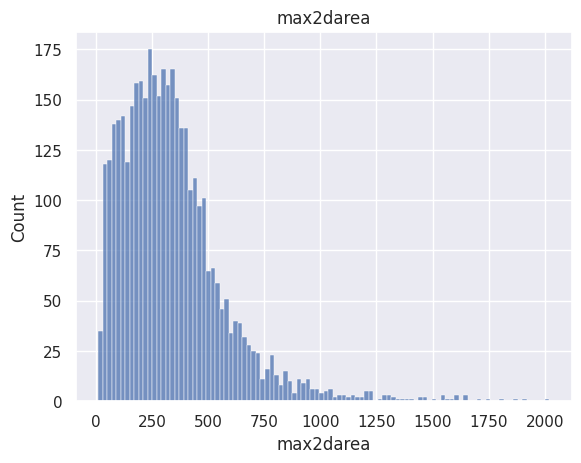

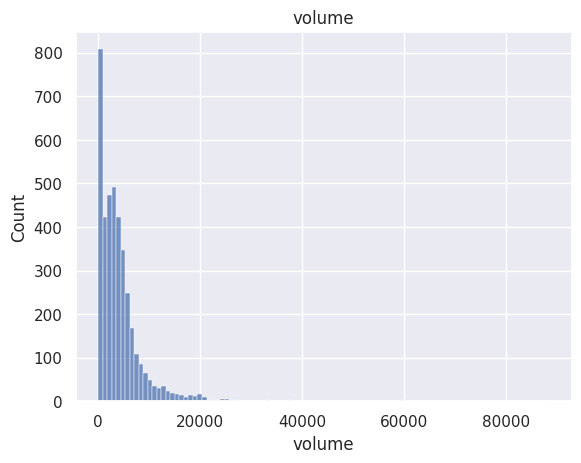

,size_x,size_y,max2dsize_x,max2dsize_y,min2darea,max2darea,volume
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000
mean,27.113127,22.852860,23.520282,21.031746,44.424540,337.994205,4340.455278
std,16.911298,13.549083,10.720851,10.171216,52.342129,236.709749,5171.445018
min,3.000000,1.000000,4.000000,2.000000,1.000000,10.000000,78.000000
25%,16.000000,15.000000,16.000000,15.000000,8.000000,175.000000,1313.000000
50%,24.000000,20.000000,23.000000,19.000000,26.000000,300.000000,3245.000000
75%,33.000000,26.000000,29.000000,25.000000,64.000000,438.000000,5413.000000
max,166.000000,137.000000,115.000000,106.000000,566.000000,2019.000000,88447.000000


In [25]:
attrs = ['size_x', 'size_y', 'max2dsize_x', 'max2dsize_y', 'min2darea', 'max2darea', 'volume']
for attr in attrs:
    sns.histplot(df_frac[attr], bins=100)
    plt.title(attr)
    plt.show()
    
df_frac[attrs].describe()

### Select `fracture_proportion_in_patch` hyperparameter

We look into the smallest fracture region we can get to define the proportion of fractures in a patch. The aim of this is not to skip small fracture region when choosing a patch that contains a fracture.

The proportion is set as follows: $$\text{fracture\_proportion\_in\_patch}=\frac{\text{smallest\_area}}{\text{selected patch\_size}}$$

where the selected `patch_size=64` from last section.

`TODO!` Empirically, we choose `smallest_area=XX` to be the best. Thus, `fracture_proportion_in_patch=XX`.

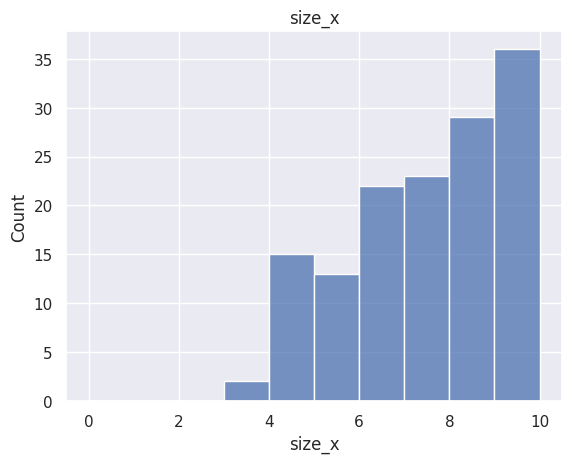

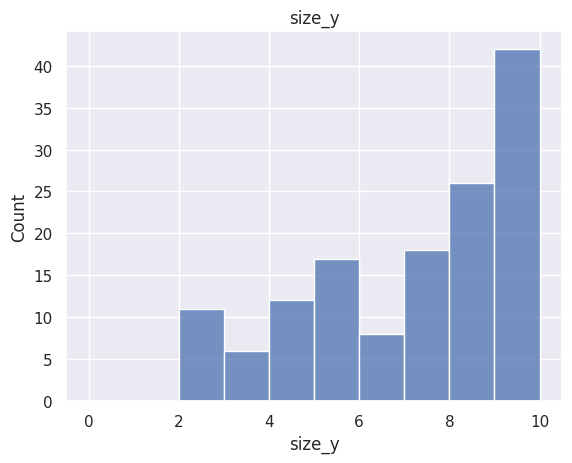

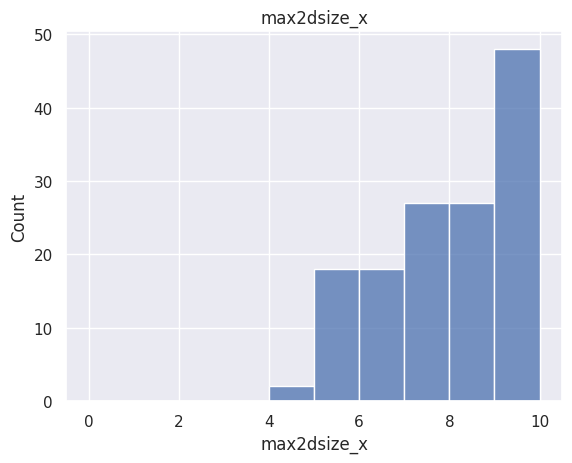

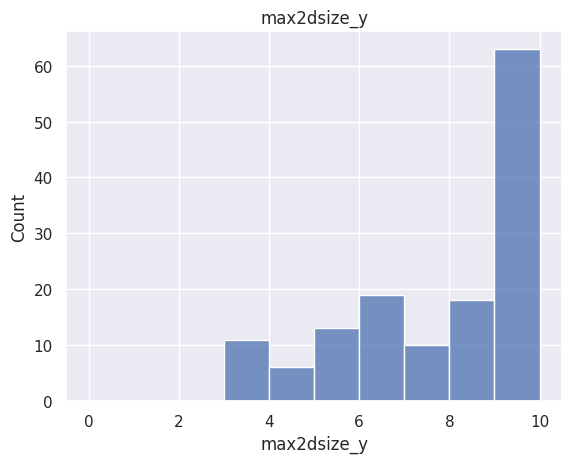

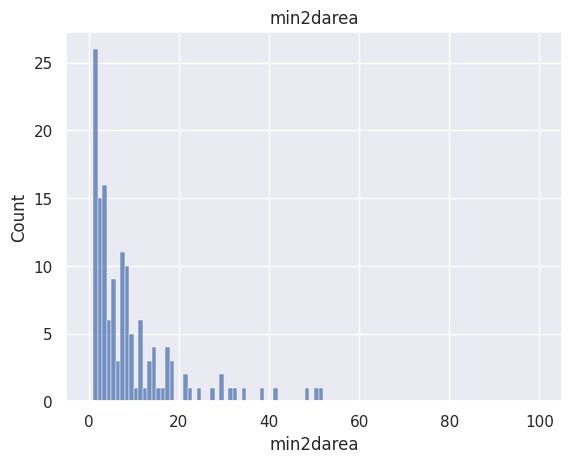

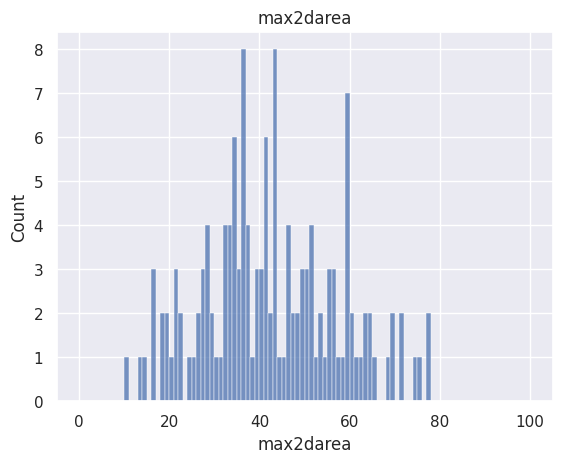

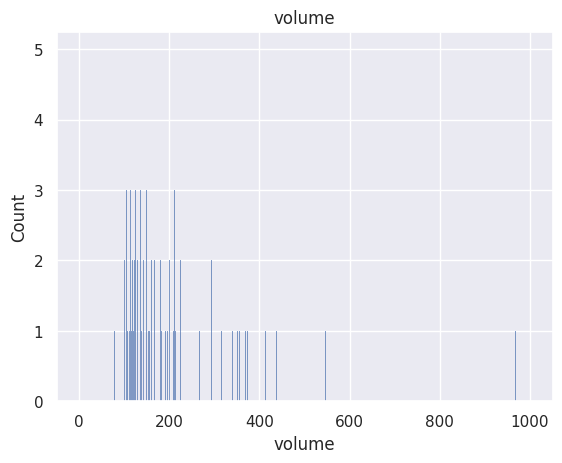

,size_x,size_y,max2dsize_x,max2dsize_y,min2darea,max2darea,volume
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,7.050000,6.721429,7.635714,7.485714,8.764286,42.164286,183.992857
std,1.796579,2.366030,1.697271,2.232802,10.172336,15.054630,107.976116
min,3.000000,2.000000,4.000000,3.000000,1.000000,10.000000,78.000000
25%,6.000000,5.000000,6.000000,6.000000,2.000000,32.750000,116.750000
50%,7.000000,7.000000,8.000000,8.000000,5.000000,41.000000,151.000000
75%,9.000000,9.000000,9.000000,9.000000,11.000000,53.000000,209.500000
max,10.000000,10.000000,10.000000,10.000000,51.000000,77.000000,967.000000


In [26]:
small_thr_size = 10
small_thr_area = small_thr_size**2
small_thr_volume = small_thr_size**3


attrs_size = ['size_x', 'size_y', 'max2dsize_x', 'max2dsize_y']
attrs_area = ['min2darea', 'max2darea']
attrs_volume = ['volume']

is_small_size = df_frac[attrs_size].max(axis=1) <= small_thr_size
is_small_area = df_frac[attrs_area].max(axis=1) <= small_thr_area
is_small_volume = df_frac[attrs_volume].max(axis=1) <= small_thr_volume
is_small = is_small_size & is_small_area & is_small_volume
df_frac_small = df_frac.loc[is_small, attrs_size + attrs_area + attrs_volume]

for attr_type, attrs, small_thr in zip(['size', 'area', 'volume'], [attrs_size, attrs_area, attrs_volume], [small_thr_size, small_thr_area, small_thr_volume]):
    for attr in attrs:
        sns.histplot(df_frac_small[attr], bins=small_thr, binrange=(0, small_thr))
        plt.title(attr)
        plt.show()
        
df_frac_small.describe()

### Fracture location distribution

We plot the location of the fractures using absolute and relative coordinates.

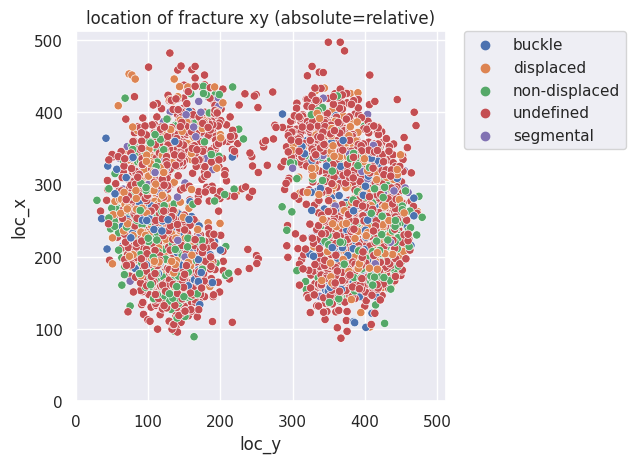

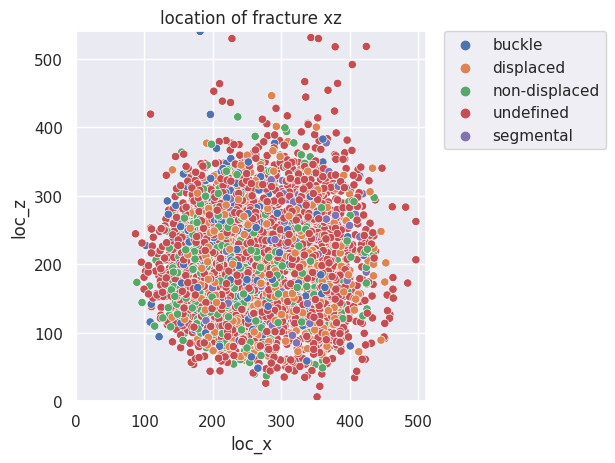

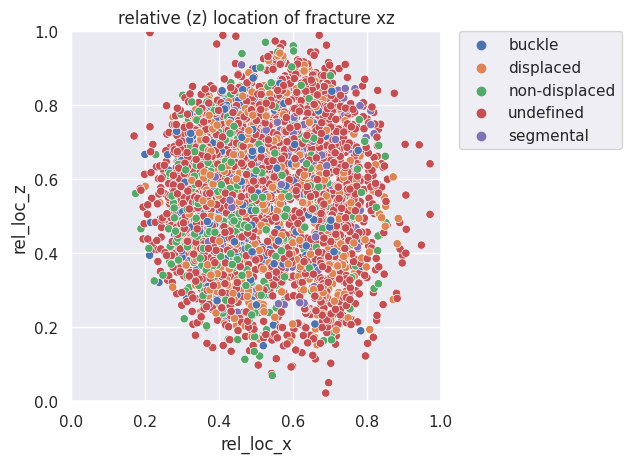

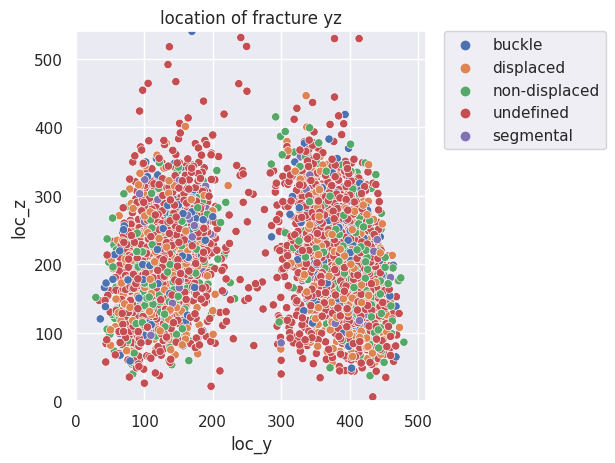

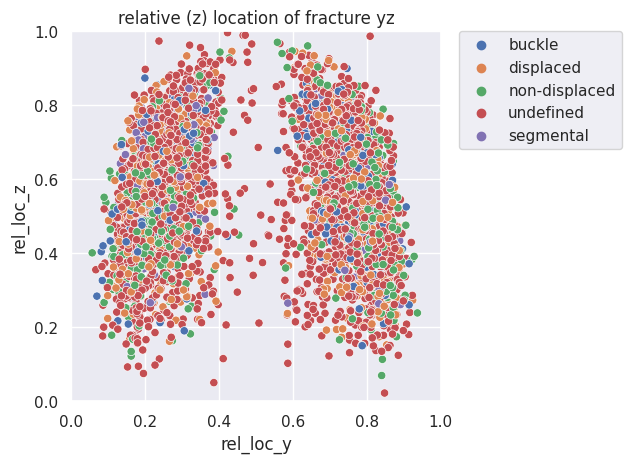

/gpfs/home2/scur0569/.venv/lib64/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


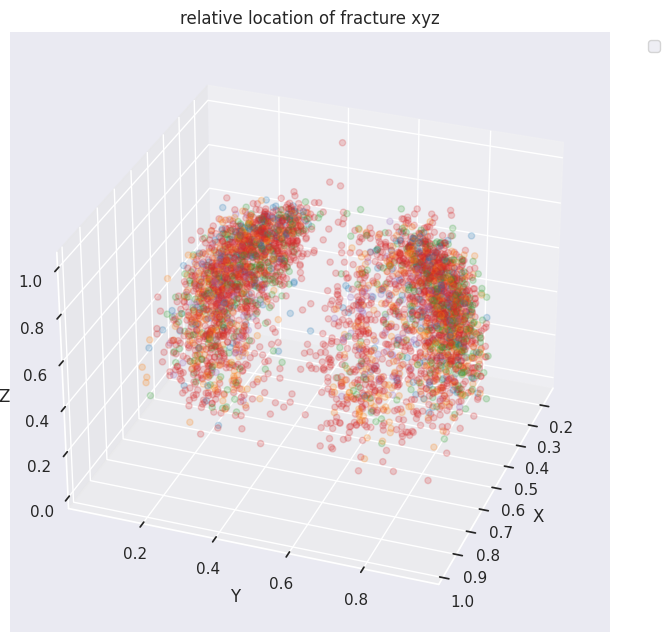

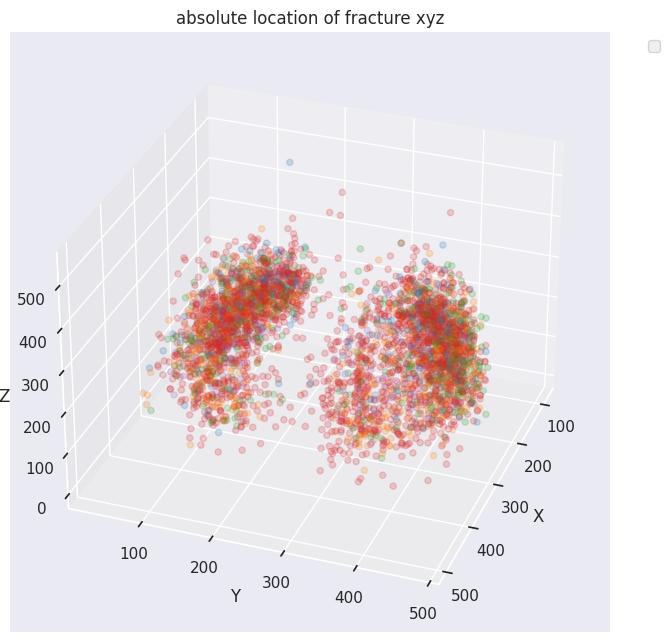

In [27]:
sns.scatterplot(data=df_frac, x='loc_y', y='loc_x', hue='frac_code_name')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 512)
plt.ylim(0, 512)
plt.title('location of fracture xy (absolute=relative)')
plt.show()

sns.scatterplot(data=df_frac, x='loc_x', y='loc_z', hue='frac_code_name')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 512)
plt.ylim(0, df_frac['loc_z'].max())
plt.title('location of fracture xz')
plt.show()

sns.scatterplot(data=df_frac, x='rel_loc_x', y='rel_loc_z', hue='frac_code_name')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('relative (z) location of fracture xz')
plt.show()

sns.scatterplot(data=df_frac, x='loc_y', y='loc_z', hue='frac_code_name')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 512)
plt.ylim(0, df_frac['loc_z'].max())
plt.title('location of fracture yz')
plt.show()

sns.scatterplot(data=df_frac, x='rel_loc_y', y='rel_loc_z', hue='frac_code_name')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('relative (z) location of fracture yz')
plt.show()

# 3d scatterplot of fracture location
da.scatter3d(df_frac['rel_loc_x'], df_frac['rel_loc_y'], df_frac['rel_loc_z'], df_frac['frac_code_name'], title='relative location of fracture xyz')
da.scatter3d(df_frac['loc_x'], df_frac['loc_y'], df_frac['loc_z'], df_frac['frac_code_name'], title='absolute location of fracture xyz')

## Testing preprocessing results

In this section we aim to test different preprocessing approaches and compare the results that different approaches yield.

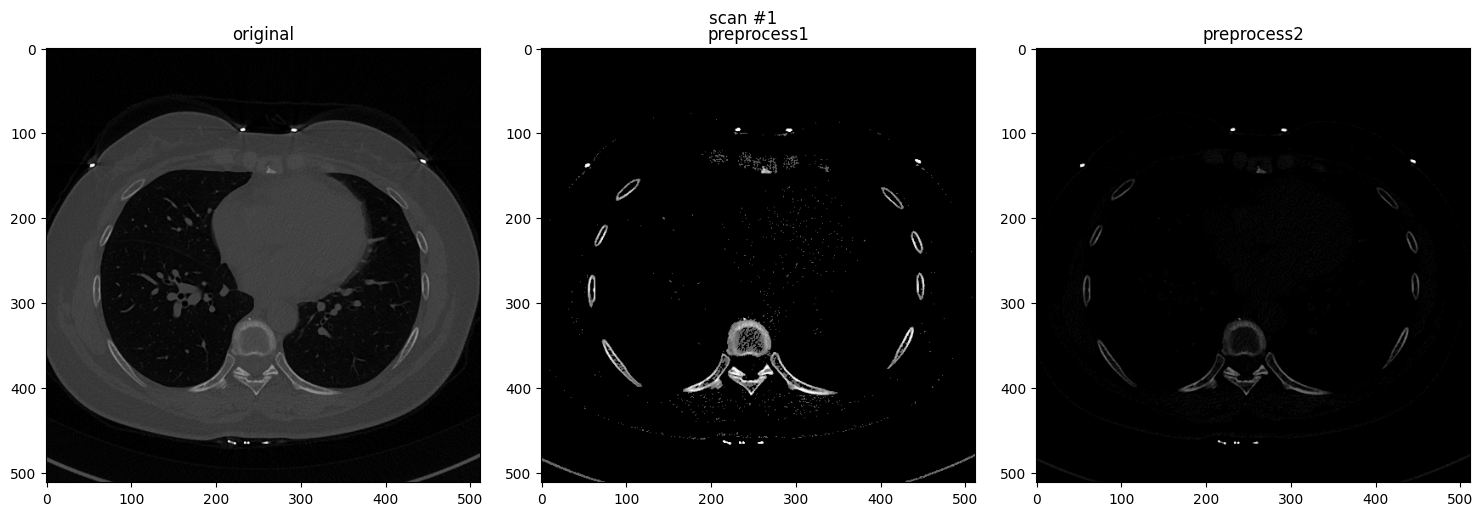

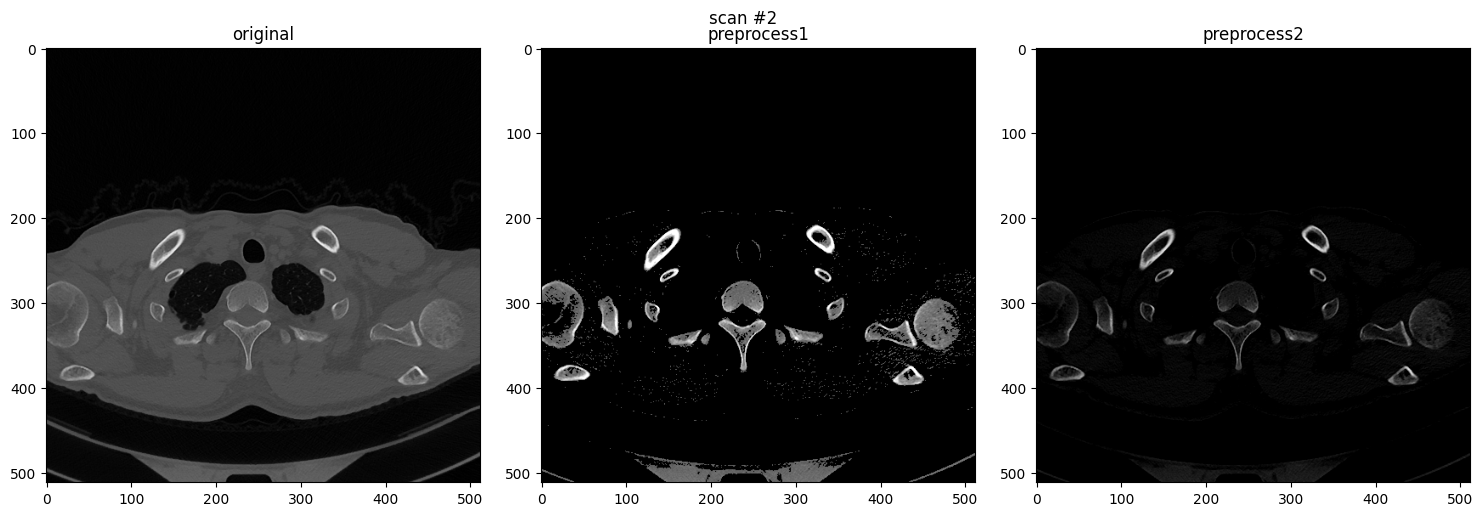

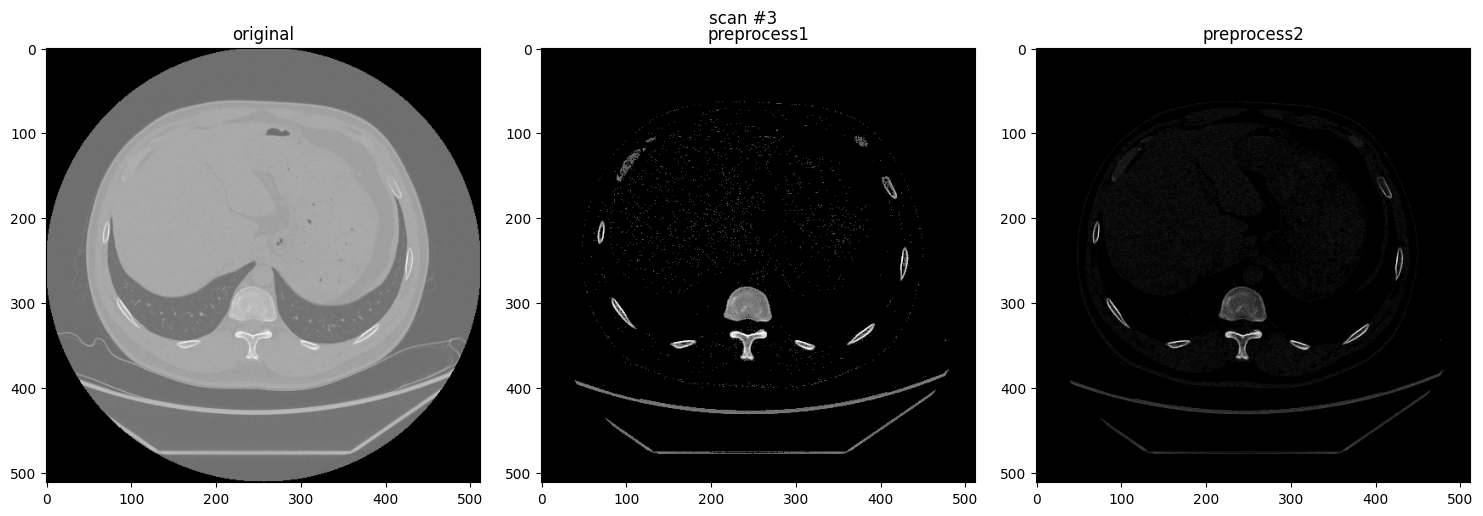

In [28]:
# preprocessing variables
level = 0.5
window = 0.1
threshold = 0.8

# comparing preprocessing methods

def preprocess1(img, level=400, window=1800, threshold=0.35):
    max_ = level + window/2
    min_ = level - window/2
    img = img.clip(min_, max_)
    img = (img - min_) / (max_ - min_)
    img[img < threshold] = 0
    return img

def preprocess2(img, threshold=0):
    img = img.copy()
    img[img < threshold] = 0
    return img

# visualize

n_images = 3
n = 0
for filename in os.listdir(TRAIN_IMAGES):
    if n >= n_images:
        break
    if 'label' in filename:
        print('WARNING: Directory structure is not as expected. Ignoring file', filename)
        continue
    else:
        n += 1
    path = os.path.join(TRAIN_IMAGES, filename)
    scan = nib.load(path).get_fdata().T.astype(float)  # (z, x, y)
    slice_idx = np.random.randint(0, scan.shape[0])  # select random slice
    slice_ = scan[slice_idx]

    imgs = [slice_, preprocess1(slice_), preprocess2(slice_)]
    titles = ['original', 'preprocess1', 'preprocess2']
    da.imshow_multiple(imgs, titles=titles, suptitle='scan #{}'.format(n))

## Voxel value analysis

In this section, we explore the voxel values of the scans, their distribution and statistics. This is helpful for several purposes:
- Select value thresholding hperparameters
- Identify problematic features in data, e.g. backplate
- Standarize data, i.e. mean and std

### Sum all scans

We sum all scan values in a single volume, using absolute coordinates and aligned at top (x=0). Pixel values should have been somehow preprocessed and thresholded beforehand.

In [29]:
cum_scans_path = os.path.join(ANALYSIS_ROOT, 'cum_scans.npy')
avg_scan_path = os.path.join(ANALYSIS_ROOT, 'avg_scan.npy')
params_path = os.path.join(ANALYSIS_ROOT, 'params.json')

if os.path.exists(cum_scans_path) and os.path.exists(avg_scan_path):
    cum_scans = np.load(cum_scans_path)
    avg_scan = np.load(avg_scan_path)
    params = da.load_params_json(params_path)
    mean, std = params['mean'], params['std']
    print('Loaded existing analysis')
else:
    print('No existing analysis found, computing...')
    mean, std, cum_scans, avg_scan = da.analysis_pixel_values(TRAIN_IMAGES, preprocess1)  # TODO: use appropiate preprocessing
    np.save(cum_scans_path, cum_scans)
    np.save(avg_scan_path, avg_scan)
    da.update_params_json(params_path, mean=mean, std=std)
    print('Saved files:',
          params_path,
          cum_scans_path,
          avg_scan_path,
          sep='\n\t')

Loaded existing analysis


### Pixel value global statistics

We compute the mean and standard deviation of pixel values of all the scans in the training set.

In [ ]:
print('mean=', mean)
print('std=', std)

### Slice projection

We perform histogram equalization on the images to improve contrast. We project all slices into a single slice so that we are able to identify a cutoff height (in x direction) to isolate backplate and artifacts.

In [30]:
cum_slice = cum_scans.sum(axis=0)

if os.path.exists(os.path.join(ANALYSIS_ROOT, 'he_scans.npy')):
    he_slice = np.load(os.path.join(ANALYSIS_ROOT, 'he_slice.npy'))
    he_scans = np.load(os.path.join(ANALYSIS_ROOT, 'he_scans.npy'))
    he_scans_slicewise = np.load(os.path.join(ANALYSIS_ROOT, 'he_scans_slicewise.npy'))
    print('Loaded existing analysis')
else:
    print('No existing analysis found, computing...')
    cum_scans = da.minmax(cum_scans)
    cum_slice = da.minmax(cum_slice)
    he_slice = da.histogram_equalization(cum_slice)
    he_scans = da.histogram_equalization(cum_scans)
    he_scans_slicewise = da.equalize_per_slice(cum_scans)
    np.save(os.path.join(ANALYSIS_ROOT, 'he_slice.npy'), he_slice)
    np.save(os.path.join(ANALYSIS_ROOT, 'he_scans.npy'), he_scans)
    np.save(os.path.join(ANALYSIS_ROOT, 'he_scans_slicewise.npy'), he_scans_slicewise)
    print('Saved files:',
          os.path.join(ANALYSIS_ROOT, 'he_slice.npy'),
          os.path.join(ANALYSIS_ROOT, 'he_scans.npy'),
          os.path.join(ANALYSIS_ROOT, 'he_scans_slicewise.npy'),
          sep='\n\t')

Loaded existing analysis


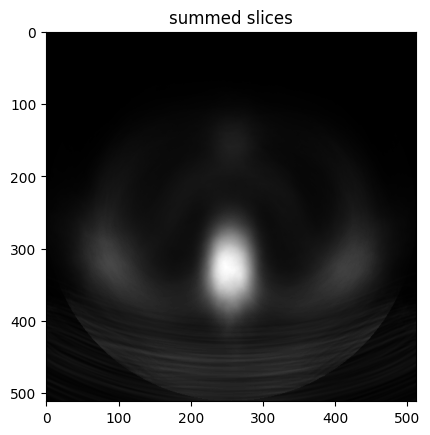

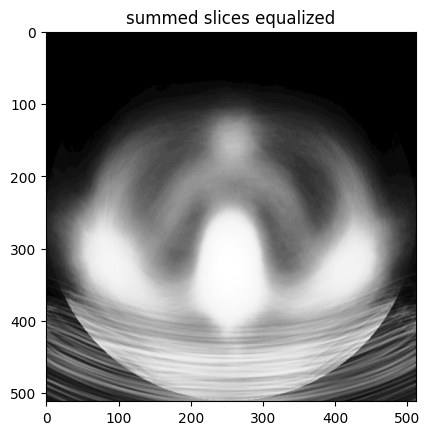

saved gif at /home/scur0569/rib-fracture/data/analysis/cum_scans.gif


saved gif at /home/scur0569/rib-fracture/data/analysis/cum_scans_equalized_slices.gif
saved gif at /home/scur0569/rib-fracture/data/analysis/cum_scans_equalized_scan.gif


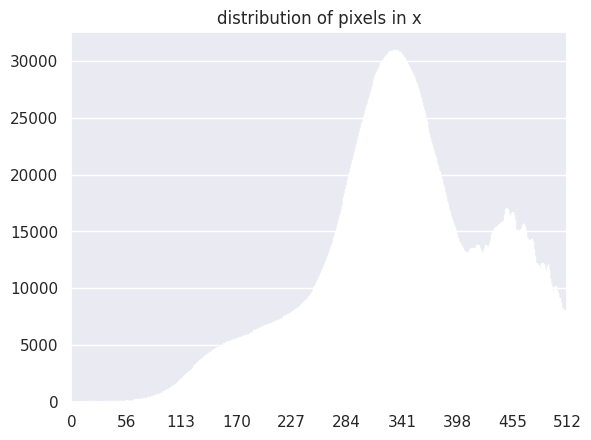

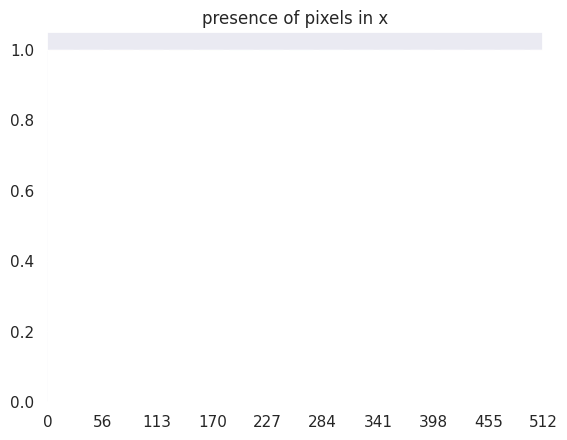

In [31]:
cum_scans = da.minmax(cum_scans)
cum_slice = da.minmax(cum_slice)
he_slice = da.minmax(he_slice)
he_scans = da.minmax(he_scans)
he_scans_slicewise = da.minmax(he_scans_slicewise)

# plot summed slices
da.imshow(cum_slice, title='summed slices', range=(0, 1))
da.imshow(he_slice, title='summed slices equalized', range=(0, 1))
# save
plt.imsave(os.path.join(ANALYSIS_ROOT, 'summed_slices.png'), cum_slice, cmap='gray')
plt.imsave(os.path.join(ANALYSIS_ROOT, 'summed_slices_equalized.png'), he_slice, cmap='gray')
da.create_gif(cum_scans, save_path=os.path.join(ANALYSIS_ROOT, 'cum_scans.gif'))
da.create_gif(he_scans_slicewise, save_path=os.path.join(ANALYSIS_ROOT, 'cum_scans_equalized_slices.gif'))
da.create_gif(he_scans, save_path=os.path.join(ANALYSIS_ROOT, 'cum_scans_equalized_scan.gif'))

# analyze distribution in x
x_distrib = cum_scans.sum(axis=(0, 2)).flatten()
sns.barplot(x=list(range(len(x_distrib))), y=x_distrib)
ticks = np.linspace(0, len(x_distrib), 10).astype(int)  # only show 10 ticks
plt.xticks(ticks, ticks)
plt.title('distribution of pixels in x')
plt.show()

x_values_bin = (x_distrib > 0).astype(int)
sns.barplot(x=list(range(len(x_values_bin))), y=x_values_bin)
plt.xticks(ticks, ticks)
plt.title('presence of pixels in x')
plt.show()

### Pixel distribution in Z

We project pixel values into Z axis so that we see bone distribution in Z, and luckily spot a cliff where there are no ribs present in a slice (slices in the bottom only contain spine).

In [32]:
# TODO: analyze distribution in z

We test the same with different alignments for the Z axis.

In [33]:
# TODO: da.analysis_cum_scans() with align=top, bottom, center, fit

## Connected component analysis

We use dilation + connected component analysis on the slice data to be able to identify and isolate the backplate. With closing or filling operations, the backplate can be identified as the biggest component in the segmentation most of the times. However, this might not always be the case. In this section we will see:
- Distribution of location of connected components.
- Distribution of areas of connected components.
- Select cutoff height (in x direction) or area threashold.
- How many times the biggest component is the backplate, based on the location of the selected component.
- How many slices don't contain a backplate, based on the amount of connected components under the cutoff hieght.

In [35]:
# TODO: connected components analysis + dilation structuring element